In [1]:
import ebsd_index
import EBSDImage.IPFcolor as ipfcolor
import matplotlib.pyplot as plt

In [2]:
file = '~/Desktop/SLMtest/scan2v3nlparl09sw7.up1'

In [3]:
dat1, indxer=ebsd_index.index_pats(filename = file,
                                     patStart = 0, patEnd = 1,return_indexer_obj = True,
                                     nTheta = 180, nRho=90,
                                     tSigma = 1.0, rSigma = 1.2,rhoMaskFrac=0.1,nBands=9, \
                                     phaselist = ['FCC'])
imshape = (indxer.fID.nRows, indxer.fID.nCols)

In [4]:
dat = ebsd_index.index_pats_distributed(filename = file,patStart = 0, patEnd = -1, chunksize = 1008, ncpu = 28, ebsd_indexer_obj = indxer)

2021-02-11 11:46:02,521	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


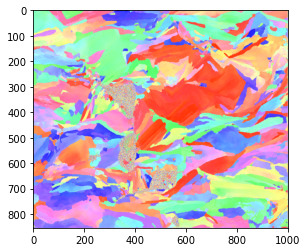

In [5]:
 ipfim = ipfcolor.ipf_color_cubic(dat['quat']).reshape(imshape[0],imshape[1],3); plt.imshow(ipfim)